In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

from sklearn.preprocessing import MinMaxScaler
import datetime

from models.aae import Encoder, Decoder
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.scaler = MinMaxScaler((-1, 1))
        self.l_dim = 2
        # self.wsize = 5
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 300
        self.sample_interval = 100
        self.train_plots = True
        
        # create ouput dirs
        # self.model_out = Path('./runs/aae2D/' + time_id)
        # if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        # (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        # self.tags = ["aae", "joint", "minmax", "test"]
        # self.desc = "2D comp (single mag)"
        # self.type = "AAE"
        
opts = Options()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)


Using device:  cuda:0


# Helper Functions

In [2]:
def fit(dataloader):
    netEnc = Encoder(
        input_size=dataloader.dataset.shape[1],
        l_dim=opts.l_dim,  
        device=device,
        slope=0.2
    ).to(device)
    netDec = Decoder(
        output_size=dataloader.dataset.shape[1],
        l_dim=opts.l_dim,
        slope=0.2
    ).to(device)
    
    # Initialize BCELoss function
    pixelwise_loss = nn.MSELoss()

    # Setup Adam optimizers for both G and D
    optmG = optim.Adam(
        itertools.chain(netEnc.parameters(), netDec.parameters()), 
        lr=opts.G_lr,
    )

    # Training Loop
    # Lists to keep track of progress
    G_losses = []
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(opts.epochs):
        G_epoch_loss = 0
        
        # For each batch in the dataloader
        for _i, (x, _filename) in enumerate(dataloader):
            bsize = x.shape[0]
            real = x.to(device)
            # ===== Train Generator =====
            optmG.zero_grad()
            enc_x = netEnc(real)
            dec_x = netDec(enc_x)
            
            # Loss measures generator's ability to fool the discriminator
            errG = pixelwise_loss(dec_x, real)
            
            errG.backward()
            optmG.step()
            G_epoch_loss += errG.item() / bsize
        
        # Output training stats
        print('[%d/%d]\tLoss_G: %.4f' % (epoch, opts.epochs, errG.item()), end='\r', flush=True)
        G_losses.append(errG.item())
        
        if errG.item() < 0.0005:
            break
        
    return netEnc, netDec
        
def transform(dataloader, netEnc):
    points = []
    for _i, (x, _filename) in enumerate(dataloader):
        x = x.to(device)
        enc_x = netEnc(x)
        enc_x = enc_x.detach().cpu().numpy()
        points.extend(list(enc_x))
    return np.array(points)

# Magnetic Field

In [3]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method="single_mag",
    remove_extreme=False,
    is_train=True,
    scaler=opts.scaler,
    nseqs=1
)
mag_dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Inputs shape: (11771, 640)
Inputs head:
 [[-0.84197182 -0.84459175 -0.84721484 ...  0.99982868  0.99984577
   0.9998612 ]
 [-0.83877989 -0.84145651 -0.84413624 ...  0.99986245  0.99987618
   0.99988857]
 [-0.83076146 -0.83357611 -0.83639389 ...  0.9998677   0.9998809
   0.99989282]
 [-0.84415331 -0.84674147 -0.84933263 ...  0.99987729  0.99988954
   0.99990059]
 [-0.83378261 -0.83655194 -0.83932417 ...  0.99986317  0.99987683
   0.99988915]]


In [4]:
netEnc_mag, _ = fit(mag_dataloader)

Starting Training Loop...


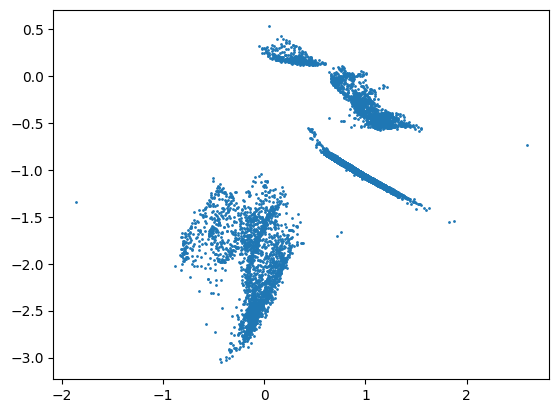

In [5]:
mag_points = transform(mag_dataloader, netEnc_mag)
plt.scatter(mag_points[:, 0], mag_points[:, 1], s=1)

# Inclination

In [6]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method="single_alpha",
    remove_extreme=False,
    is_train=True,
    scaler=opts.scaler,
)
alpha_dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Inputs shape: (11771, 640)
Inputs head:
 [[ 0.1999884   0.20079141  0.20160554 ... -1.         -1.
  -1.        ]
 [ 0.2347334   0.23580007  0.23688186 ... -1.         -1.
  -1.        ]
 [ 0.26966237  0.27096428  0.27228496 ... -1.         -1.
  -1.        ]
 [ 0.16532924  0.16629741  0.16727945 ... -1.         -1.
  -1.        ]
 [ 0.23831219  0.23962488  0.24095667 ... -1.         -1.
  -1.        ]]


In [7]:
netEnc_alpha, _ = fit(alpha_dataloader)

Starting Training Loop...


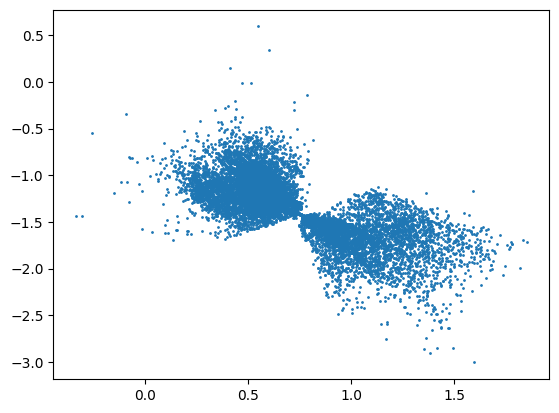

In [8]:
alpha_points = transform(alpha_dataloader, netEnc_alpha)
plt.scatter(alpha_points[:, 0], alpha_points[:, 1], s=1)

# Joint

In [9]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method="joint",
    remove_extreme=False,
    is_train=True,
    scaler=opts.scaler,
)
joint_dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Inputs shape: (11771, 1280)
Inputs head:
 [[-0.84197182 -0.84459175 -0.84721484 ... -1.         -1.
  -1.        ]
 [-0.83877989 -0.84145651 -0.84413624 ... -1.         -1.
  -1.        ]
 [-0.83076146 -0.83357611 -0.83639389 ... -1.         -1.
  -1.        ]
 [-0.84415331 -0.84674147 -0.84933263 ... -1.         -1.
  -1.        ]
 [-0.83378261 -0.83655194 -0.83932417 ... -1.         -1.
  -1.        ]]


In [10]:
netEnc_joint, _ = fit(joint_dataloader)

Starting Training Loop...


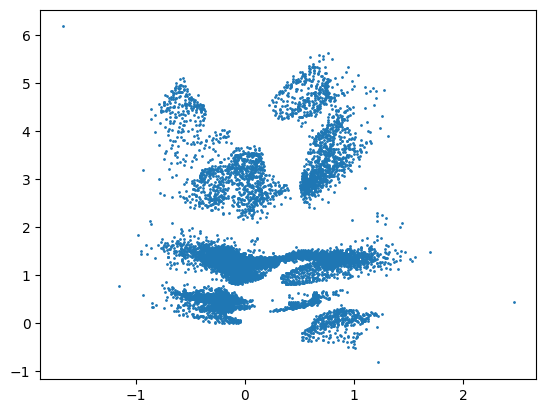

In [11]:
joint_points = transform(joint_dataloader, netEnc_joint)
plt.scatter(joint_points[:, 0], joint_points[:, 1], s=1)